### **D2APR: Aprendizado de Máquina e Reconhecimento de Padrões** (IFSP, Campinas) <br/>
**Trabalho 1 - Sao Paulo Real Estate**

Aluno: Hugo Martinelli Watanuki

Matrícula: 3016692

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>. <br/><br/>

In [67]:
# Importing base libraries for the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#**1. Problem description and dataset**

##1.1 Problem statement
Stablishing the correct rental value for an apartment in Sao Paulo can be very challenging.

Irrespective of you being the owner or the tenant of the apartment, both parties want to ensure they are practicing prices that are in accordance with the most up to date values being practiced in the market.

However, the rental prices in a large metropolitan area like São Paulo can be influenced by serveral different factors, including not only internal attributes of the apartment, such as square footage and number of bedrooms,but also external elements such as its localization and surrounding infrastructure.

Therefore, the goal of this notebook is to develop a machine learning model that can help owner and tenants interested in renting an apartment to predict the a reference rental price according to the market standards. To this aim, a dataset containing records of apartments from Sao Paulo and their corresponding attributes will be leveraged.





##1.2 Dataset overview

The dataset being leveraged in this notebook is available from kaggle: https://www.kaggle.com/datasets/argonalyst/sao-paulo-real-estate-sale-rent-april-2019/

The dataset contains around 13.000 records where each instance represent an apartment either for sale or for rent in the city of São Paulo, Brazil. The data comes from multiple sources, specially real estate classified websites.

The dataset represents properties advertised in the month of April 2019.


In [68]:
housing = pd.read_csv('./sample_data/sao-paulo-properties-april-2019.csv')

In [69]:
housing.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


##1.3 Dataset attributes and data types

In [70]:
housing.describe(include='all')

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
count,1.364000e+04,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.000000,13640.00000,13640.000000,13640,13640,13640,13640.000000,13640.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96,2,1,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moema/São Paulo,rent,apartment,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293,7228,13640,NaN,NaN
mean,2.877378e+05,689.882331,84.373900,2.312023,2.073680,0.980792,1.393182,0.354179,0.146774,0.51217,0.015616,NaN,NaN,NaN,-22.077047,-43.597088
std,5.908214e+05,757.649363,58.435676,0.777461,0.961803,0.834891,0.829932,0.478281,0.353894,0.49987,0.123988,NaN,NaN,NaN,5.866633,11.487288
min,4.800000e+02,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN,-46.749039,-58.364352
25%,1.858750e+03,290.000000,50.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,NaN,-23.594552,-46.681671
50%,8.100000e+03,500.000000,65.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.00000,0.000000,NaN,NaN,NaN,-23.552813,-46.637255
75%,3.600000e+05,835.000000,94.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.00000,0.000000,NaN,NaN,NaN,-23.517640,-46.560040


In [71]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             13640 non-null  int64  
 1   Condo             13640 non-null  int64  
 2   Size              13640 non-null  int64  
 3   Rooms             13640 non-null  int64  
 4   Toilets           13640 non-null  int64  
 5   Suites            13640 non-null  int64  
 6   Parking           13640 non-null  int64  
 7   Elevator          13640 non-null  int64  
 8   Furnished         13640 non-null  int64  
 9   Swimming Pool     13640 non-null  int64  
 10  New               13640 non-null  int64  
 11  District          13640 non-null  object 
 12  Negotiation Type  13640 non-null  object 
 13  Property Type     13640 non-null  object 
 14  Latitude          13640 non-null  float64
 15  Longitude         13640 non-null  float64
dtypes: float64(2), int64(11), object(3)
memo

Each row corresponds to one apartment and is represented by 16 attributes (9 numeric and 17 categorical).

*   Price: Final price advertised (R$ Brazilian Real)
*   Condo: Condominium expenses (unknown values are marked as zero)
*   Size: The property size in Square Meters m² (private areas only)
*   Rooms: Number of bedrooms
*   Toilets: Number of toilets (all toilets)
*   Suites: Number of bedrooms with a private bathroom (en suite)
*   Parking: Number of parking spots
*   Elevator: Binary value: 1 if there is elevator in the building, 0 otherwise
*   Furnished: Binary value: 1 if the property is funished, 0 otherwise
*   Swimming Pool: Binary value: 1 if the property has swimming pool, 0 otherwise

There are 13,640 instances in the dataset (fairly small by ML standards).
There are no missing values reported in any of the features, but the feature "Condo" has unknown values represented as zero.

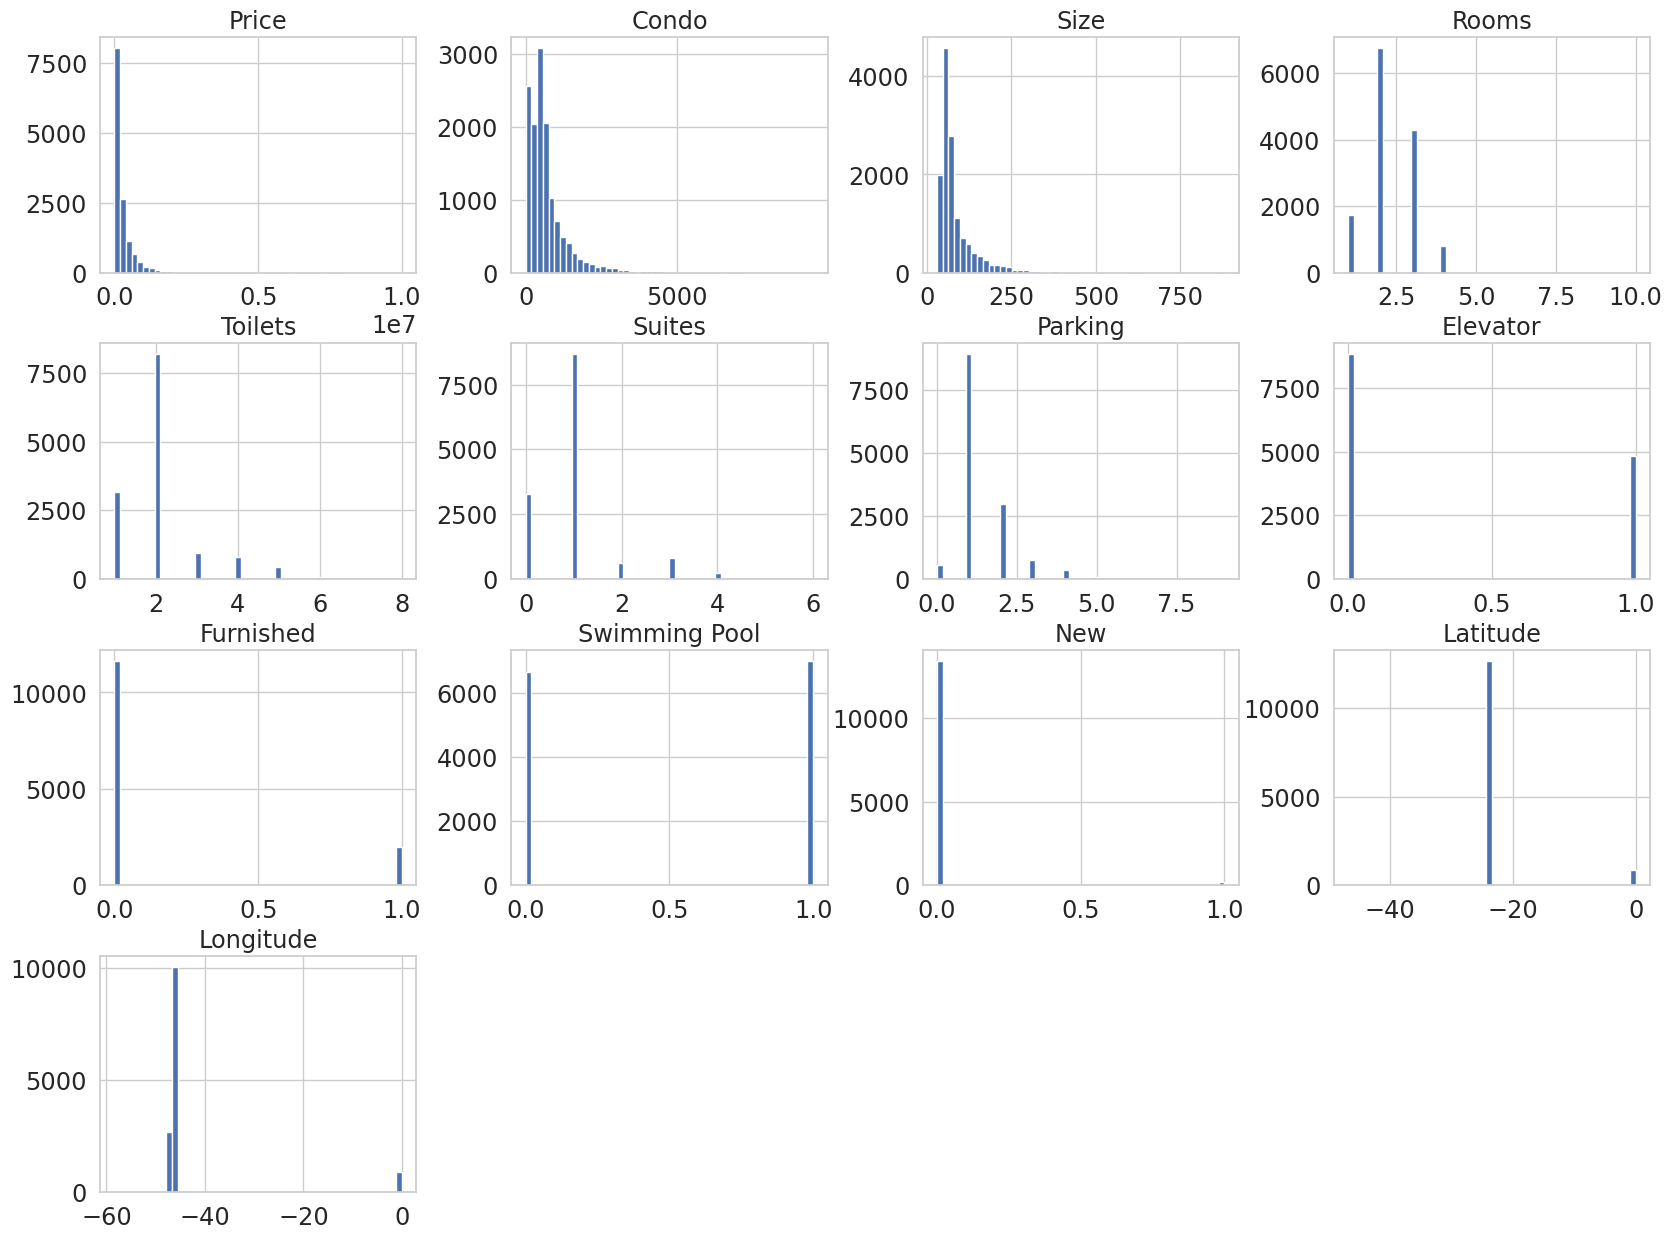

In [72]:
# plot a histogram for each numeric attibute from the dataframe
housing.hist(bins=50, figsize=(20,15))
display()  # just to avoid texts in the notebook output

In [73]:
housing['District'].value_counts()

Moema/São Paulo              293
Mooca/São Paulo              288
Brás/São Paulo               255
Brooklin/São Paulo           250
Bela Vista/São Paulo         250
                            ... 
Jardim São Luis/São Paulo     44
São Rafael/São Paulo          44
Grajaú/São Paulo              37
São Domingos/São Paulo        35
Perus/São Paulo               30
Name: District, Length: 96, dtype: int64

In [74]:
housing['Negotiation Type'].value_counts()

rent    7228
sale    6412
Name: Negotiation Type, dtype: int64

In [75]:
housing['Property Type'].value_counts()

apartment    13640
Name: Property Type, dtype: int64

# Ps.: One specific concern for the categorial variables is that their proportions in the population are not uniform and can generate bias if proper care is not taken during sampling

## 3. Preprocessing the data

3.1 segmenting the core predictor (size)


In [76]:
housing_rent=housing[housing['Negotiation Type']=='rent']
housing_rent

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11205,3700,595,73,1,2,1,1,0,0,1,0,Brooklin/São Paulo,rent,apartment,-23.617682,-46.694963
11206,21000,3000,208,4,4,3,3,1,1,1,0,Brooklin/São Paulo,rent,apartment,-23.606891,-46.695934
11207,3800,710,55,1,1,0,1,0,1,1,0,Brooklin/São Paulo,rent,apartment,0.000000,0.000000
11208,5000,2354,205,3,2,1,2,1,0,0,0,Brooklin/São Paulo,rent,apartment,-23.612287,-46.681482


<Axes: xlabel='Size', ylabel='Count'>

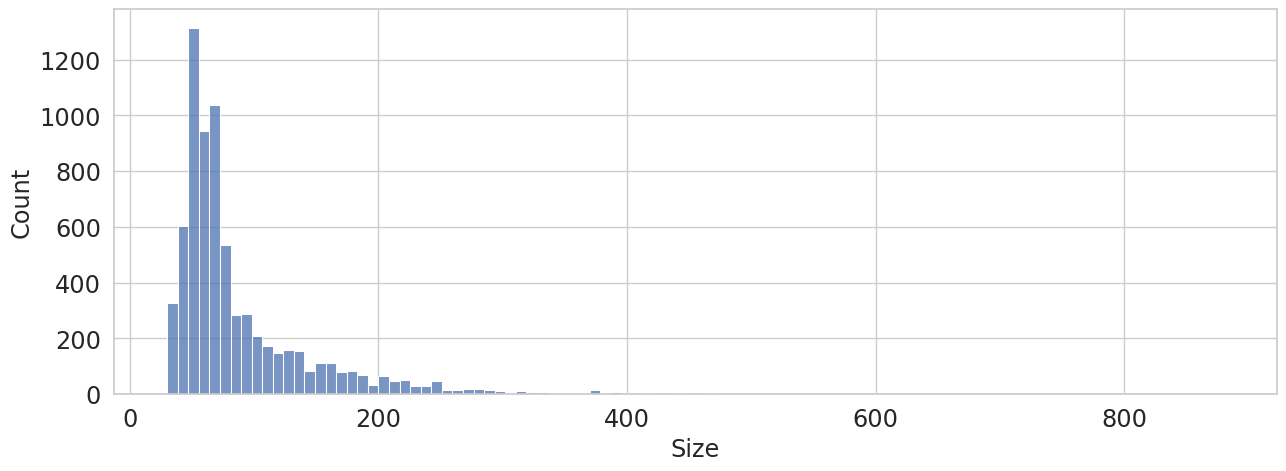

In [77]:
sns.histplot(data=housing_rent, x='Size', bins=100)

Group 1: [0, 50]
Group 2: (50, 100]
Group 3: (100, 150]
Group 4: (150, +]


In [78]:
housing_rent['Size'].describe()

count    7228.000000
mean       89.486165
std        63.976416
min        30.000000
25%        52.000000
50%        67.000000
75%       100.000000
max       880.000000
Name: Size, dtype: float64

In [79]:
housing_rent['Size_group'] = pd.cut(housing_rent['Size'], bins=[0, 50, 100, 150, np.inf],
                                        labels=[1, 2, 3, 4], include_lowest=True)

<ipython-input-79-807f7266c6b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_rent['Size_group'] = pd.cut(housing_rent['Size'], bins=[0, 50, 100, 150, np.inf],


In [80]:
housing_rent.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,Size_group
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486,1
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718,1
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665,1
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014,1
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436,2


In [81]:

housing_rent['Size_group'].value_counts()

2    3721
1    1727
4     920
3     860
Name: Size_group, dtype: int64

In [82]:
# proportional of the groups in the entire dataset
housing_rent['Size_group'].value_counts() / len(housing_rent['Size_group'])

2    0.514804
1    0.238932
4    0.127283
3    0.118982
Name: Size_group, dtype: float64

<Axes: xlabel='Size_group', ylabel='Count'>

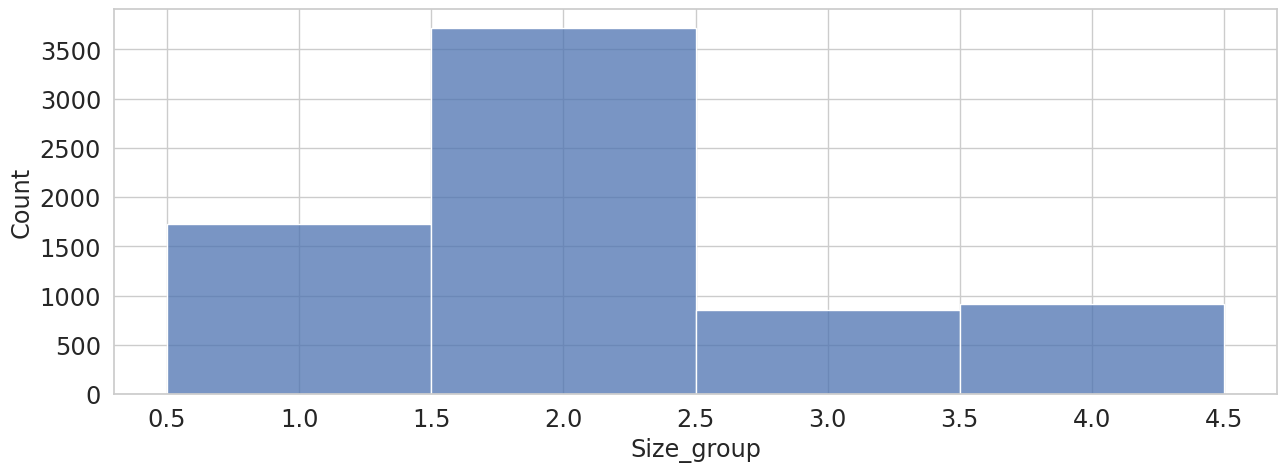

In [83]:

sns.histplot(housing_rent['Size_group'])


In [84]:
from sklearn.model_selection import train_test_split

housing_rent_train, housing_rent_test = train_test_split(housing_rent, test_size=0.2, stratify=housing_rent['Size_group'], random_state=42)

In [85]:
housing_rent_train.shape

(5782, 17)

In [86]:
housing_rent_train.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,Size_group
10890,2100,597,78,3,2,1,2,0,0,1,0,Jaguaré/São Paulo,rent,apartment,-23.552138,-46.743094,2
10645,4000,1000,103,2,1,0,1,0,0,0,0,Jardim Paulista/São Paulo,rent,apartment,-23.573779,-46.654831,3
3409,3500,620,49,1,2,1,1,0,0,0,0,Campo Belo/São Paulo,rent,apartment,-23.620655,-46.677333,1
3778,4000,2700,111,2,2,1,1,0,0,0,0,Jardim Paulista/São Paulo,rent,apartment,0.000000,0.000000,3
1938,2500,465,36,1,2,1,1,1,0,1,0,Perdizes/São Paulo,rent,apartment,-23.535704,-46.672360,1


In [87]:
# proportion of the groups in the training set
housing_rent_train['Size_group'].value_counts() / len(housing_rent_train['Size_group'])

2    0.514874
1    0.238845
4    0.127292
3    0.118990
Name: Size_group, dtype: float64

In [88]:
housing_rent_test.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,Size_group
3331,4000,1123,160,3,4,3,3,0,0,1,0,Cambuci/São Paulo,rent,apartment,-23.570246,-46.622185,4
3171,1500,971,95,3,2,1,2,0,0,1,0,São Lucas/São Paulo,rent,apartment,-23.586563,-46.548985,2
10803,10000,2250,208,4,5,4,4,0,0,1,0,Vila Mariana/São Paulo,rent,apartment,-23.598988,-46.633500,4
9205,2700,861,58,2,2,1,1,1,1,1,0,Liberdade/São Paulo,rent,apartment,-23.565184,-46.643505,2
1203,5800,1169,110,2,2,1,1,1,1,0,0,Jardim Paulista/São Paulo,rent,apartment,-23.568349,-46.650414,3


In [89]:
housing_rent_test.shape

(1446, 17)

In [90]:
# proportion of the groups in the testing set
housing_rent_test['Size_group'].value_counts() / len(housing_rent_test['Size_group'])

2    0.514523
1    0.239281
4    0.127248
3    0.118949
Name: Size_group, dtype: float64

In [91]:
# removing the attribute 'median_income_group'
housing_rent_train = housing_rent_train.drop(columns=['Size_group'])
housing_rent_test = housing_rent_test.drop(columns=['Size_group'])

In [92]:
# if you want to keep the reference for the row indices from the original dataset, remove the index=False
housing_rent_train.to_csv('./sample_data/housing_rent_train.csv', index=False)
housing_rent_test.to_csv('./sample_data/housing_rent_test.csv', index=False)

## 3. Data Cleaning

In [93]:

housing_rent_train = pd.read_csv('./sample_data/housing_rent_train.csv')

In [94]:
housing_rent_train = housing_rent_train.drop(columns=['Property Type','Negotiation Type'])

condo column has zero for unknown values

In [95]:
housing_rent_train['Condo'].value_counts()

0       528
500     144
600     121
400     106
450     100
       ... 
5636      1
5250      1
2256      1
313       1
906       1
Name: Condo, Length: 1096, dtype: int64

<Axes: xlabel='Condo'>

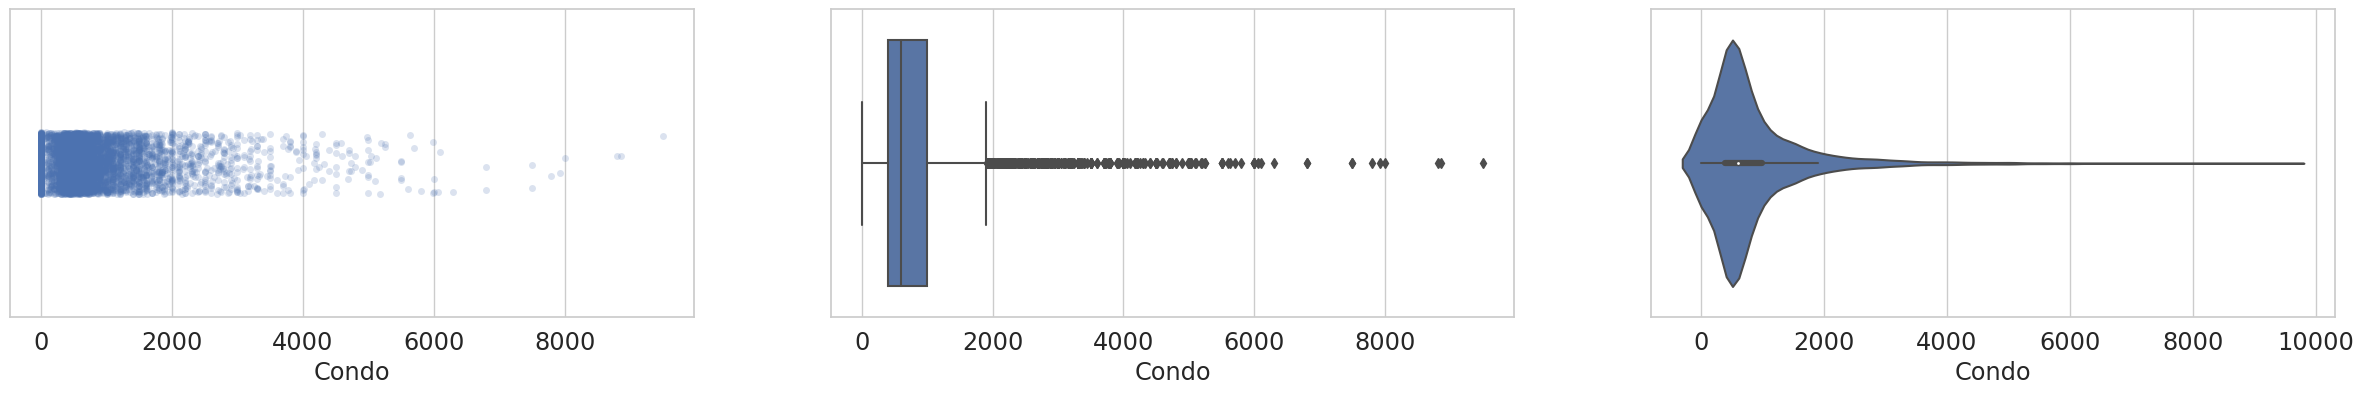

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(30, 4))

sns.stripplot(data=housing_rent_train, x='Condo', ax=axes[0], alpha=0.2)
sns.boxplot(data=housing_rent_train, x='Condo', ax=axes[1])
sns.violinplot(data=housing_rent_train, x='Condo', ax=axes[2])

In [97]:

housing_rent_train_clean = housing_rent_train.copy()

In [98]:
median_Condo = housing_rent_train_clean['Condo'].median()
median_Condo

597.0

In [99]:
mask_zeroes = housing_rent_train_clean[housing_rent_train_clean['Condo']==0]
mask_zeroes

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
24,1500,0,40,1,1,0,1,0,0,0,0,Saúde/São Paulo,-23.614958,-46.622913
36,1200,0,42,2,2,1,1,1,0,1,0,Itaquera/São Paulo,-23.560670,-46.450742
40,1400,0,52,2,2,1,1,1,0,0,0,Butantã/São Paulo,-23.580896,-46.773719
52,5000,0,128,3,4,1,3,0,1,1,0,Alto de Pinheiros/São Paulo,-23.538675,-46.713429
58,900,0,49,2,2,1,1,0,0,0,0,Raposo Tavares/São Paulo,-23.603123,-46.797977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5725,8000,0,273,10,4,1,8,0,0,0,0,Santo Amaro/São Paulo,-23.626021,-46.682821
5732,950,0,56,2,1,0,1,0,0,0,0,José Bonifácio/São Paulo,-23.547159,-46.437578
5739,8000,0,373,4,6,4,4,0,0,1,0,Morumbi/São Paulo,-23.622943,-46.735851
5749,1200,0,90,2,2,1,1,0,0,0,0,Capão Redondo/São Paulo,-23.664693,-46.770211


In [100]:
housing_rent_train_clean['Condo'] = housing_rent_train_clean['Condo'].replace(0, median_Condo)





In [101]:
mask_zeroes = housing_rent_train_clean[housing_rent_train_clean['Condo']==0]
mask_zeroes

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude


In [102]:
#housing_rent_train_clean.loc[24]

In [103]:
housing_rent_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          5782 non-null   int64  
 1   Condo          5782 non-null   int64  
 2   Size           5782 non-null   int64  
 3   Rooms          5782 non-null   int64  
 4   Toilets        5782 non-null   int64  
 5   Suites         5782 non-null   int64  
 6   Parking        5782 non-null   int64  
 7   Elevator       5782 non-null   int64  
 8   Furnished      5782 non-null   int64  
 9   Swimming Pool  5782 non-null   int64  
 10  New            5782 non-null   int64  
 11  District       5782 non-null   object 
 12  Latitude       5782 non-null   float64
 13  Longitude      5782 non-null   float64
dtypes: float64(2), int64(11), object(1)
memory usage: 632.5+ KB


### 0. Imports and default settings for plotting

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## 4. Explore the data

<Axes: xlabel='Longitude', ylabel='Latitude'>

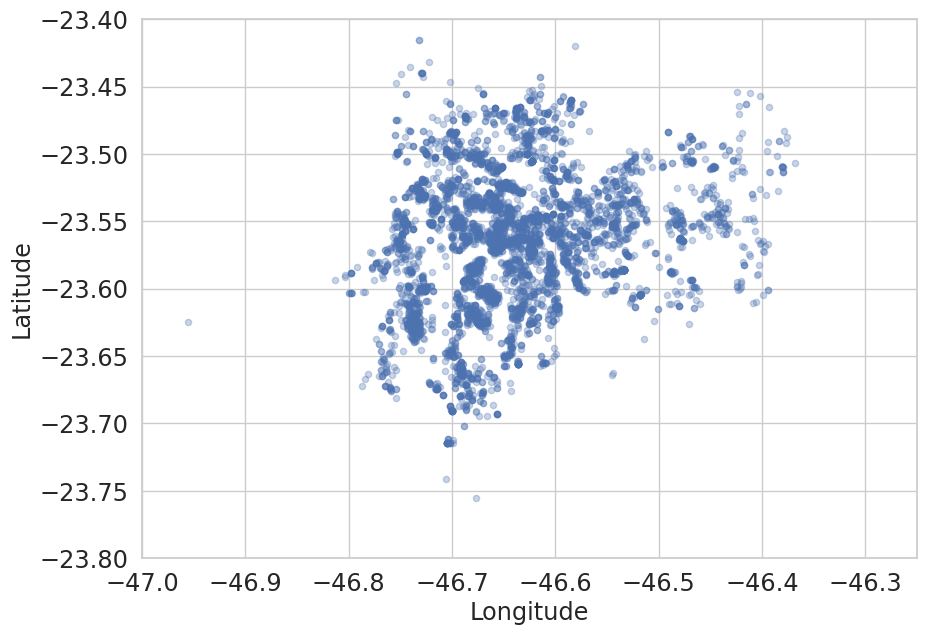

In [105]:
housing_rent_train_clean.plot(kind="scatter", x="Longitude", y="Latitude", xlim=(-47,-46.25), ylim=(-23.8, -23.4), alpha=0.3, figsize=(10, 7))

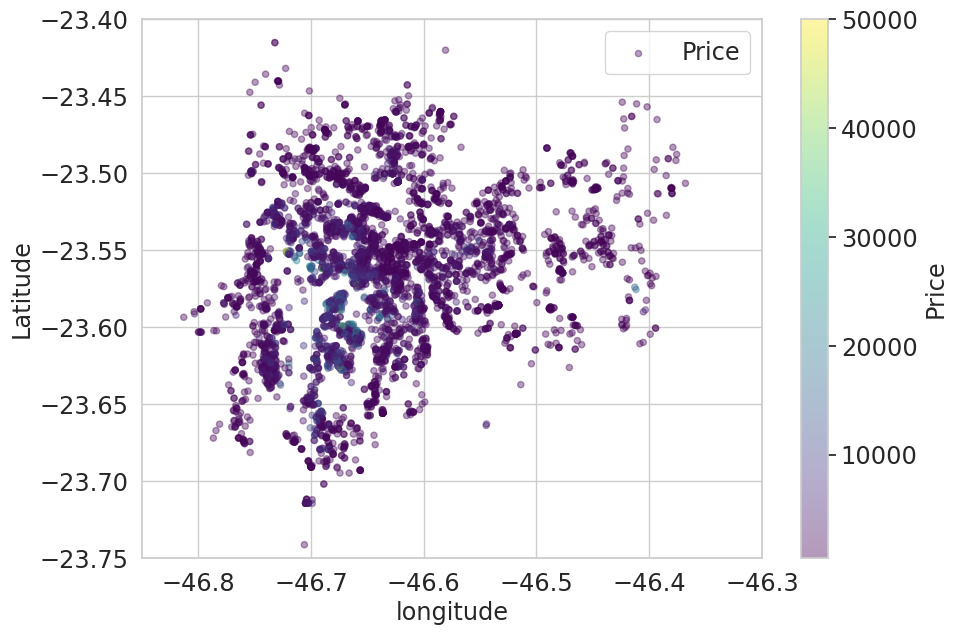

In [106]:
housing_rent_train_clean.plot(kind="scatter", x="Longitude", y="Latitude", xlim=(-46.85,-46.3), ylim=(-23.75, -23.4), label ="Price", alpha=0.4,  figsize=(10,7), c="Price", cmap=plt.get_cmap("viridis"), colorbar=True)
plt.xlabel('longitude')
plt.legend()

#4.2 Correlations

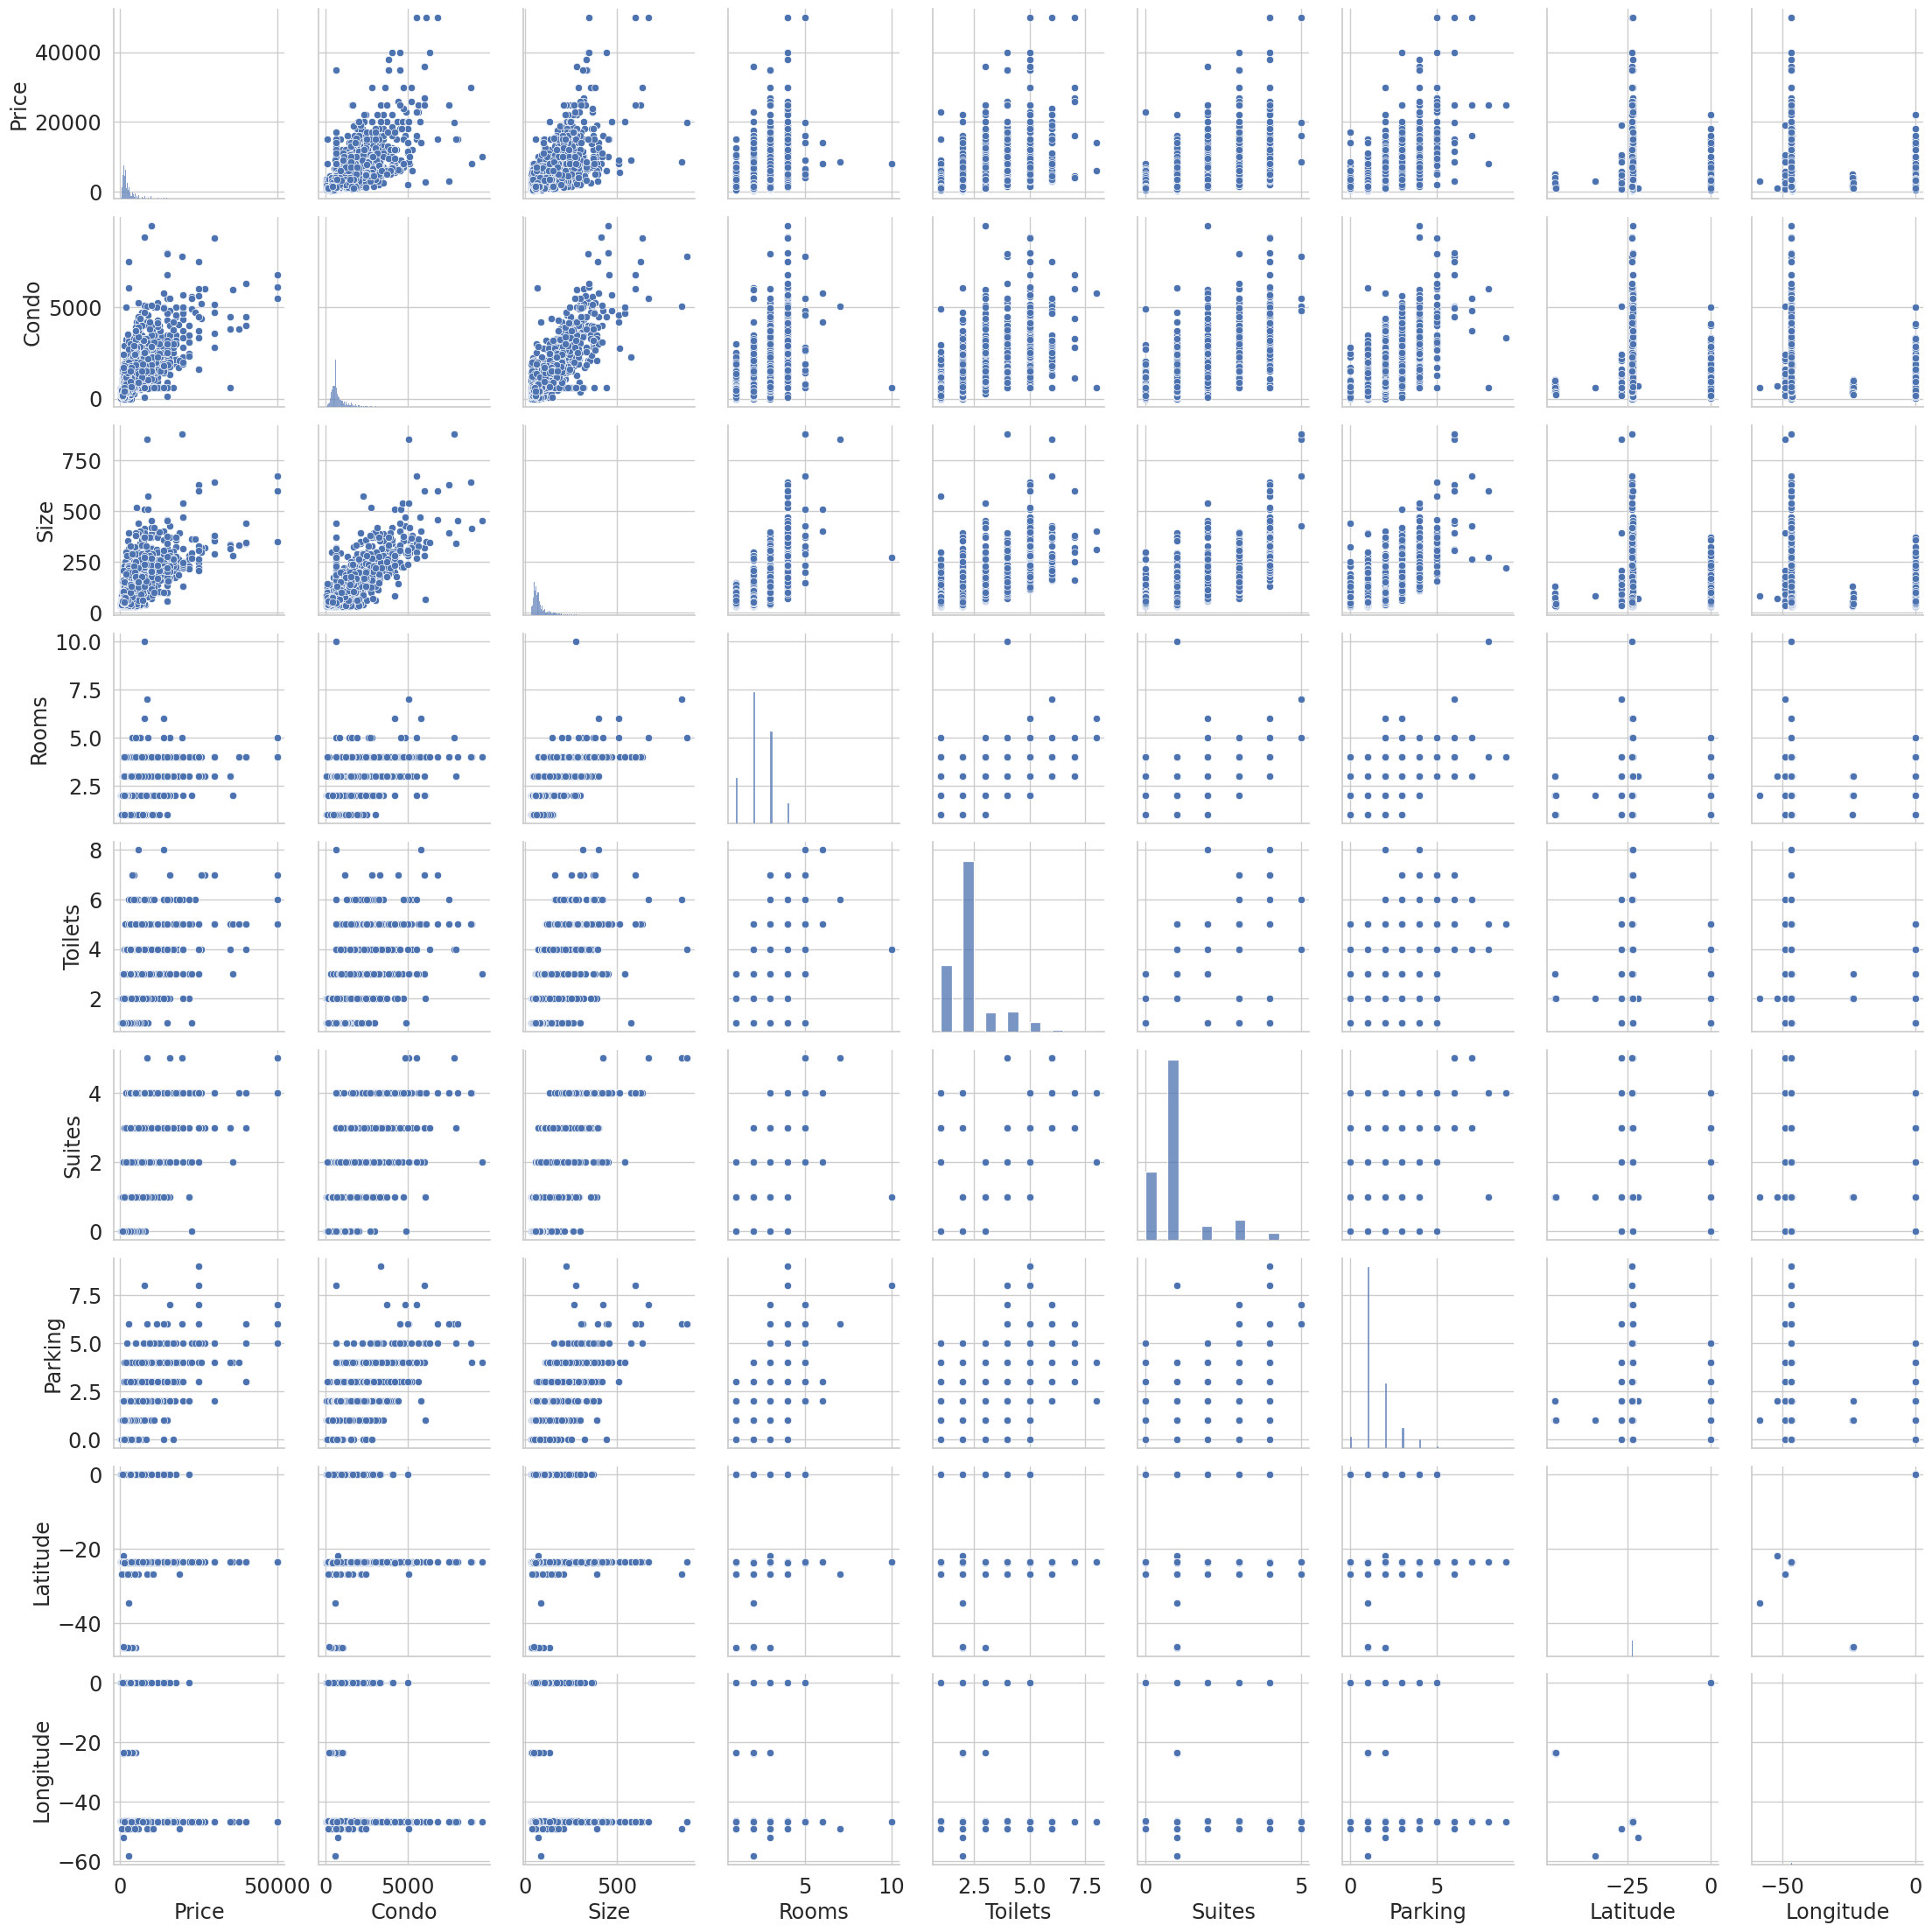

In [107]:
# 9 numeric attributes ==> 9 x 9 = 81 plots
#sns.pairplot(data=housing_rent_train_clean)
sns.pairplot(housing_rent_train_clean, vars=["Price","Condo","Size","Rooms","Toilets","Suites","Parking","Latitude","Longitude"])

<ipython-input-108-376475016d06>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(housing_rent_train_clean.corr(numeric_only=True), dtype=np.bool))  # creates a triangular matrix based on the pandas correlation matrix


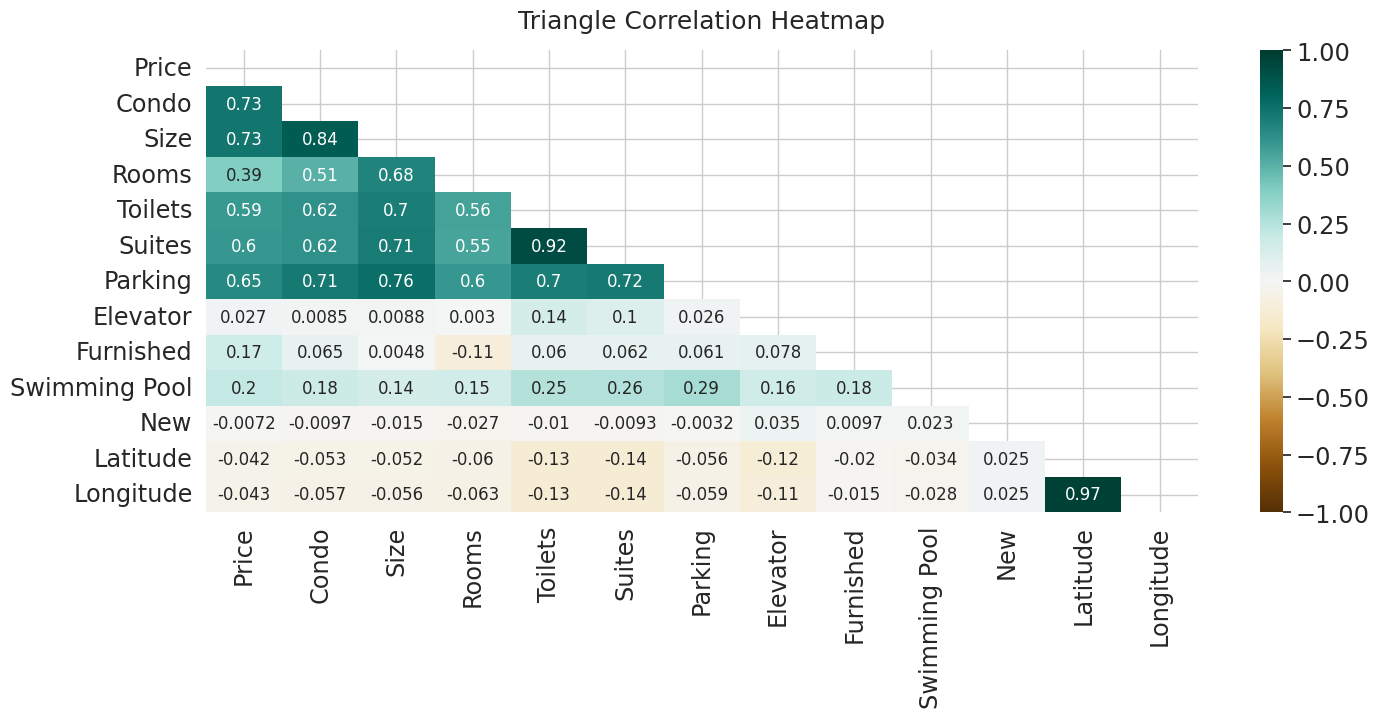

In [108]:
# plotting the correlation coeficients as a heatmap
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(housing_rent_train_clean.corr(numeric_only=True), dtype=np.bool))  # creates a triangular matrix based on the pandas correlation matrix

heatmap = sns.heatmap(housing_rent_train_clean.corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [109]:
housing_rent_train_clean.corr(numeric_only=True)["Price"].sort_values(ascending=False)

Price            1.000000
Size             0.730698
Condo            0.729646
Parking          0.650624
Suites           0.597162
Toilets          0.592374
Rooms            0.393931
Swimming Pool    0.203833
Furnished        0.165829
Elevator         0.027352
New             -0.007235
Latitude        -0.041886
Longitude       -0.043485
Name: Price, dtype: float64

<Figure size 1000x600 with 0 Axes>

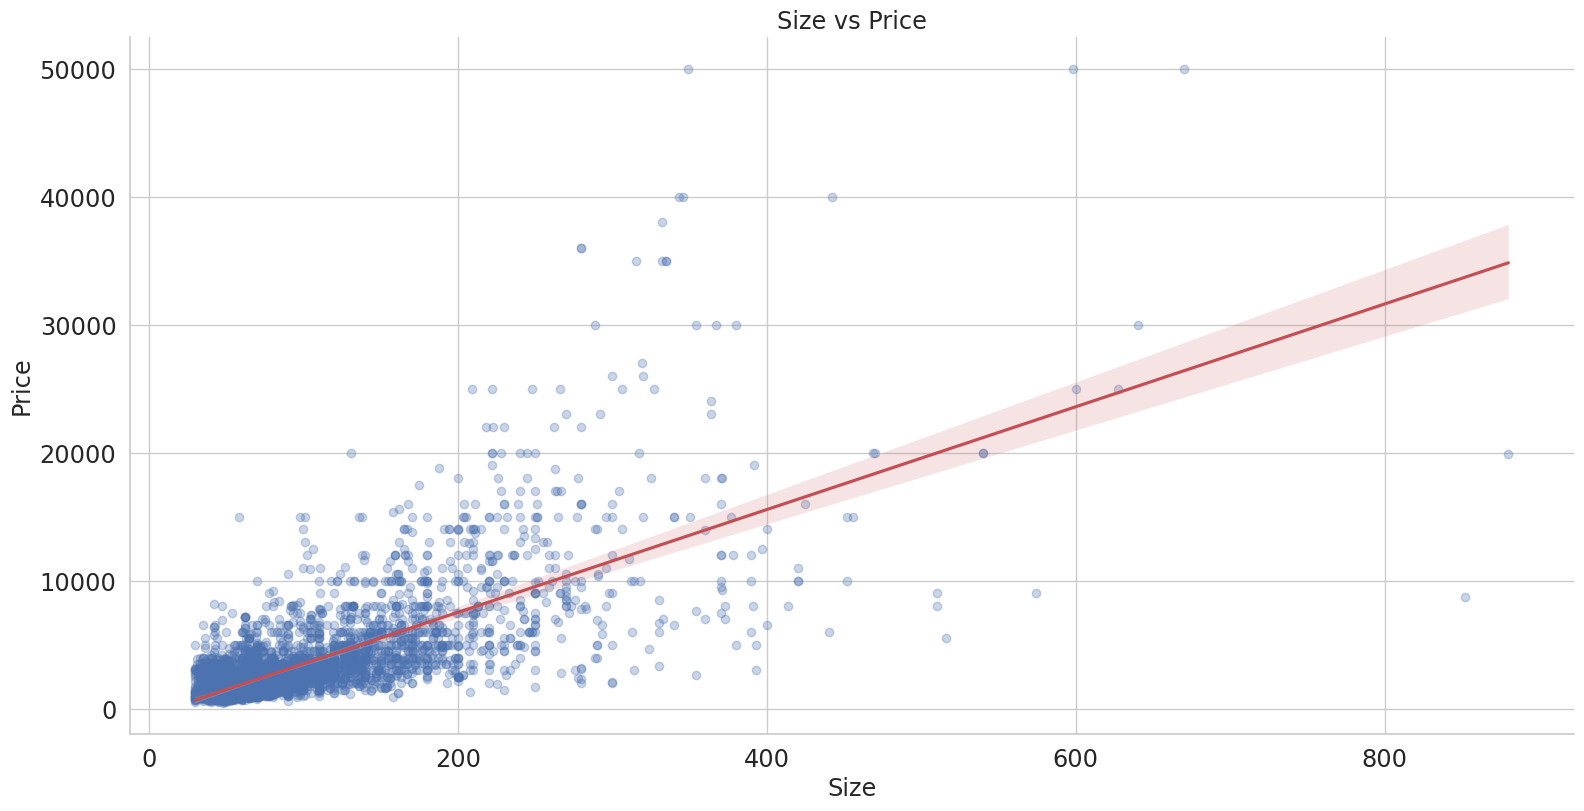

In [110]:
plt.figure(figsize=(10, 6))
sns.lmplot(data=housing_rent_train_clean, x="Size", y="Price", aspect=2, height=8, scatter_kws={'alpha': 0.3}, line_kws={'color': 'r'})
#plt.yticks(range(0, 700001, 25000))
plt.grid(True)
plt.title('Size vs Price')
display()

#4.3 Data Distribution

In [111]:
housing_rent_train_clean.columns

Index(['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking',
       'Elevator', 'Furnished', 'Swimming Pool', 'New', 'District', 'Latitude',
       'Longitude'],
      dtype='object')

In [112]:
numeric_attributes = ['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking']


numeric_attributes

['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking']

In [113]:
len(numeric_attributes)

7

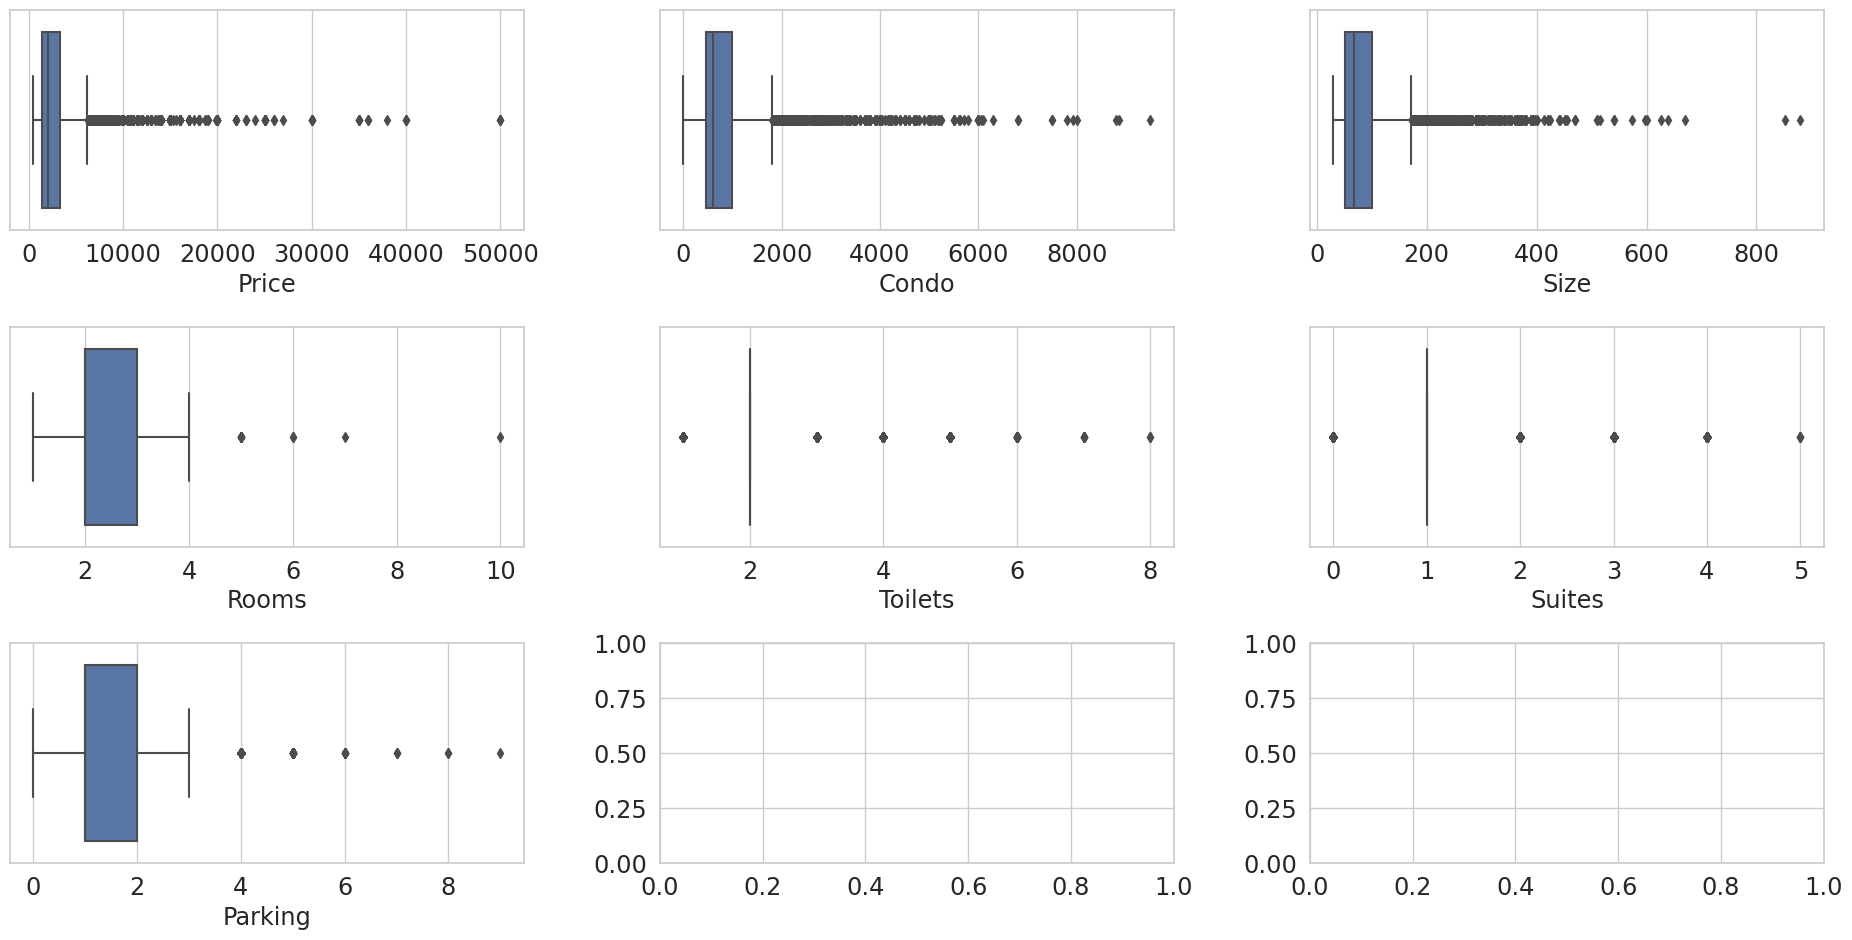

In [114]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
fig.tight_layout(pad=3.0)

for i, attr in enumerate(numeric_attributes):
    row = i // 3
    col = i % 3
    sns.boxplot(data=housing_rent_train_clean, x=attr, ax=axes[row, col])

## 5. Prepare the data

In [115]:
housing_rent_train_clean.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
0,2100,597,78,3,2,1,2,0,0,1,0,Jaguaré/São Paulo,-23.552138,-46.743094
1,4000,1000,103,2,1,0,1,0,0,0,0,Jardim Paulista/São Paulo,-23.573779,-46.654831
2,3500,620,49,1,2,1,1,0,0,0,0,Campo Belo/São Paulo,-23.620655,-46.677333
3,4000,2700,111,2,2,1,1,0,0,0,0,Jardim Paulista/São Paulo,0.000000,0.000000
4,2500,465,36,1,2,1,1,1,0,1,0,Perdizes/São Paulo,-23.535704,-46.672360


In [116]:
housing_rent_train_target = housing_rent_train_clean['Price'].copy()  # y = 1D array
housing_rent_train_pre = housing_rent_train_clean.drop(columns=['Price'])  # X = 2D array, feature matrix


# 5.1 Enconding

In [117]:
housing_rent_train_pre['District'].value_counts()

Mooca/São Paulo              137
Morumbi/São Paulo            132
Moema/São Paulo              132
Cambuci/São Paulo            128
Pinheiros/São Paulo          126
                            ... 
Ponte Rasa/São Paulo           7
Parque do Carmo/São Paulo      5
Guaianazes/São Paulo           5
Jardim São Luis/São Paulo      2
Grajaú/São Paulo               2
Name: District, Length: 94, dtype: int64

In [118]:
# one hot encoding by pandas
housing_rent_train_pre = pd.get_dummies(data=housing_rent_train_pre, columns=['District'])
housing_rent_train_pre.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,...,District_Vila Jacuí/São Paulo,District_Vila Leopoldina/São Paulo,District_Vila Madalena/São Paulo,District_Vila Maria/São Paulo,District_Vila Mariana/São Paulo,District_Vila Matilde/São Paulo,District_Vila Olimpia/São Paulo,District_Vila Prudente/São Paulo,District_Vila Sônia/São Paulo,District_Água Rasa/São Paulo
0,597,78,3,2,1,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1000,103,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,620,49,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2700,111,2,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,465,36,1,2,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
housing_rent_train_pre_saving = housing_rent_train_pre.copy()
housing_rent_train_pre_saving['Price'] = housing_rent_train_target
housing_rent_train_pre_saving.to_csv('./sample_data/housing_rent_train_prep.csv', index=False)

## 🏋️‍♀️ 6. Train ML Algorithms

6.1. Getting the independent (features) and dependent variables (outcome)

In [120]:
type(housing_rent_train_pre)

pandas.core.frame.DataFrame

In [121]:
type(housing_rent_train_target)

pandas.core.series.Series

In [122]:
# convert Pandas to numpy arrays
X_train = housing_rent_train_pre.values
y_train = housing_rent_train_target.values

In [123]:
housing_rent_train_pre.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,...,District_Vila Jacuí/São Paulo,District_Vila Leopoldina/São Paulo,District_Vila Madalena/São Paulo,District_Vila Maria/São Paulo,District_Vila Mariana/São Paulo,District_Vila Matilde/São Paulo,District_Vila Olimpia/São Paulo,District_Vila Prudente/São Paulo,District_Vila Sônia/São Paulo,District_Água Rasa/São Paulo
0,597,78,3,2,1,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1000,103,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,620,49,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2700,111,2,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,465,36,1,2,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
X_train[:5]

array([[ 5.97000000e+02,  7.80000000e+01,  3.00000000e+00,
         2.00000000e+00,  1.00000000e+00,  2.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00, -2.35521376e+01, -4.67430944e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+0

In [125]:
X_train[:, 3]

array([2., 1., 2., ..., 2., 2., 2.])

In [126]:
y_train.shape

(5782,)

6.2. Training the Models

In [127]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()  # default hyperparameters

# training
lin_reg.fit(X_train, y_train)

LinearRegression()

6.3. Evaluating on the Training Set

In [128]:
y_train_pred = lin_reg.predict(X_train)

In [129]:
r2_score = lin_reg.score(X_train, y_train)
print(f'R2 = {r2_score}')

R2 = 0.6983474689411867


In [130]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'RMSE = {rmse}')

RMSE = 1973.246282186102


Text(0.5, 1.0, 'Rent value - Prediction vs Real')

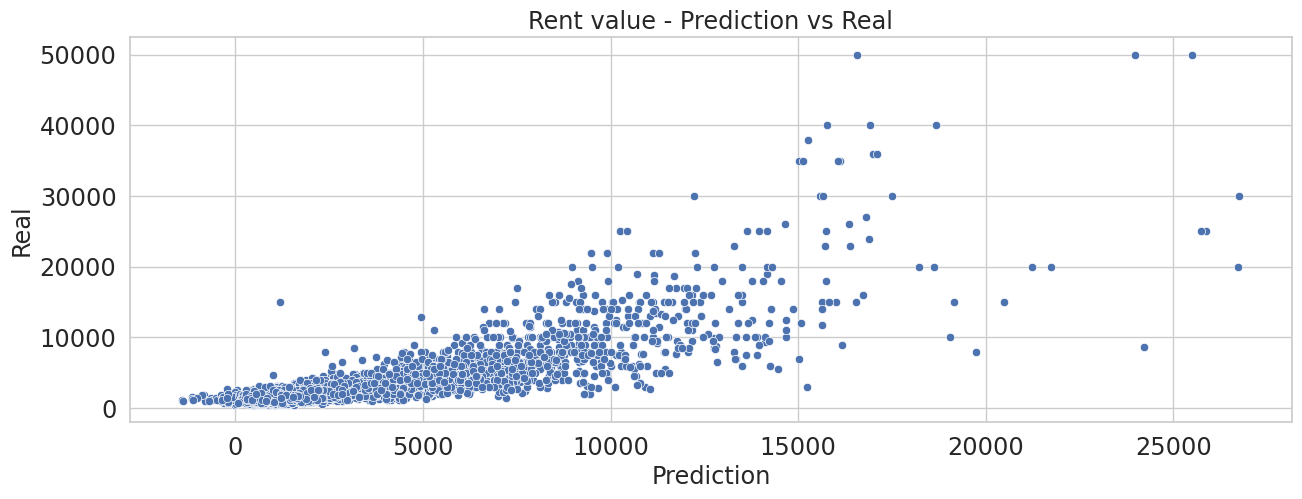

In [132]:
sns.scatterplot(x=y_train_pred, y=y_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Rent value - Prediction vs Real')

In [133]:
residual = y_train - y_train_pred

Text(0.5, 1.0, 'Rent value - Prediction vs Residual')

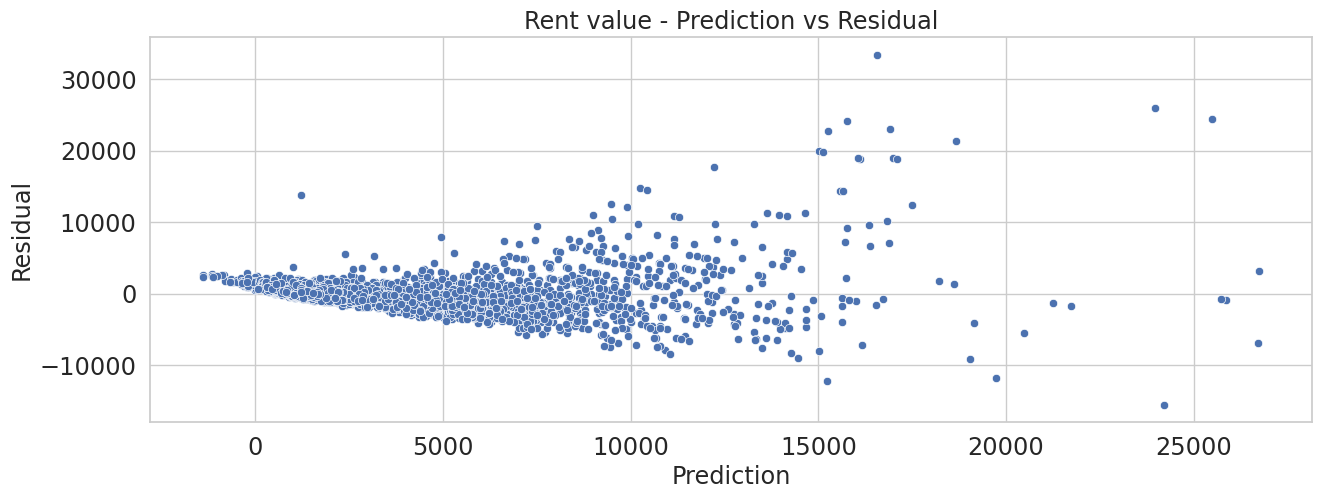

In [134]:
sns.scatterplot(x=y_train_pred, y=residual)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Rent value - Prediction vs Residual')

<Axes: ylabel='Count'>

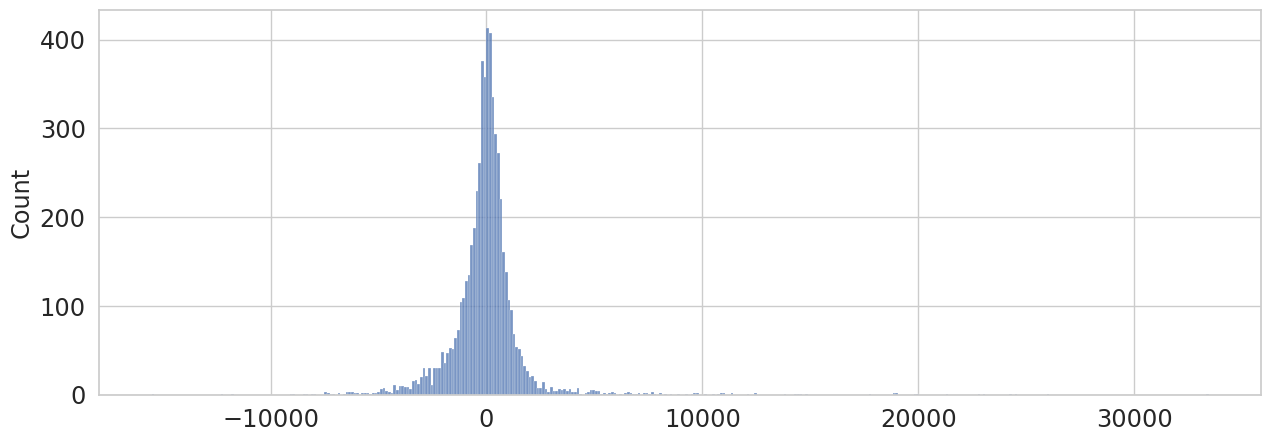

In [135]:
sns.histplot(residual)